# Land Use Classification using MicrosoftML
In this notebook, we illustrate how one can produce a deep learning model to classify aerial images based on land use type (developed, forested, cultivated, etc.). We apply transfer learning with MicrosoftML to adapt a pretrained featurizer for our classification use case.

<a name="prep"></a>
## Prepare deep learning framework-specific input files

If you have not generated your own training and validation sets through image extraction, download the following files and decompress them in your VM's temporary (`D:\`) storage:
- [Balanced training image set (~3 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_training_set.zip)
- [Balanced validation image set (~1 GB)](https://mawahstorage.blob.core.windows.net/aerialimageclassification/imagesets/balanced_validation_set.zip)

The image sets linked above contain raw PNG images sorted into folders by their assigned label. 

Update the `training_image_dir` variable below to reflect the directory where your training and validation sets have been saved. The `label_to_number_dict` variable specifies the correspondence between the label names and a numeric code; it does not need to be modified unless you have changed the labeling scheme.

In [1]:
import os, sys
import numpy as np
import pandas as pd
from sklearn.decomposition import IncrementalPCA
from sklearn.metrics import confusion_matrix, accuracy_score

import revoscalepy as revo
import microsoftml as ml

import utils.connection_settings as cs
import utils.land_use_classification_utils as luc

training_image_dir = cs.TRAINING_IMAGE_DIR
validation_image_dir = cs.VALIDATION_IMAGE_DIR
test_image_dir = cs.TEST_IMAGE_DIR
label_to_number_dict = {'Barren': 0,
                        'Forest': 1,
                        'Shrub': 2,
                        'Cultivated': 3,
                        'Herbaceous': 4,
                        'Developed': 5}

# Autoreload when modules are changed
%load_ext autoreload
%autoreload 2

# Show matplotlib plots inline
%matplotlib inline

# Set recursion limit to be slightly larger to accommodate larger formulas (which are paresed recursively)
print("Old recursion limit: ", sys.getrecursionlimit())
sys.setrecursionlimit(1500)
print("New recursion limit: ", sys.getrecursionlimit())

Old recursion limit:  1000
New recursion limit:  1500


In [2]:
# Connect to SQL Server
connection_string = cs.get_connection_string()
sql = revo.RxInSqlServer(connection_string=connection_string)
local = revo.RxLocalSeq()
revo.rx_set_compute_context(local)

DRIVER={ODBC Driver 13 for SQL Server};SERVER=TYLER-LAPTOP\TYLERSQLSERVER;PORT=21816;DATABASE=land_use_database;UID=demo;PWD=D@tascience


## Featurize Training Images

In [3]:
train_data = luc.gather_data(training_image_dir, label_to_number_dict)
print(train_data.head())
print(train_data.shape)

                                               image  label
0  C:\Users\t-tyrome\Documents\Internship\LandUse...      0
1  C:\Users\t-tyrome\Documents\Internship\LandUse...      0
2  C:\Users\t-tyrome\Documents\Internship\LandUse...      0
3  C:\Users\t-tyrome\Documents\Internship\LandUse...      0
4  C:\Users\t-tyrome\Documents\Internship\LandUse...      0
(44184, 2)


In [5]:
refeatureize = False
if refeatureize:
    featurized_train_data = compute_features(train_data, cs.MICROSOFTML_MODEL_NAME, compute_context=None)
    print(featurized_train_data.head())

    train_features_sql = revo.RxSqlServerData(table=cs.TABLE_TRAIN_FEATURES, connection_string=connection_string)
    revo.rx_data_step(featurized_train_data, train_features_sql, overwrite=True)

## Train Model

In [6]:
train_features_sql = revo.RxSqlServerData(table=cs.TABLE_TRAIN_FEATURES, connection_string=connection_string)

In [8]:
formula = luc.create_formula(train_features_sql, is_dataframe=False)
print(formula)

label ~ f0 + f1 + f2 + f3 + f4 + f5 + f6 + f7 + f8 + f9 + f10 + f11 + f12 + f13 + f14 + f15 + f16 + f17 + f18 + f19 + f20 + f21 + f22 + f23 + f24 + f25 + f26 + f27 + f28 + f29 + f30 + f31 + f32 + f33 + f34 + f35 + f36 + f37 + f38 + f39 + f40 + f41 + f42 + f43 + f44 + f45 + f46 + f47 + f48 + f49 + f50 + f51 + f52 + f53 + f54 + f55 + f56 + f57 + f58 + f59 + f60 + f61 + f62 + f63 + f64 + f65 + f66 + f67 + f68 + f69 + f70 + f71 + f72 + f73 + f74 + f75 + f76 + f77 + f78 + f79 + f80 + f81 + f82 + f83 + f84 + f85 + f86 + f87 + f88 + f89 + f90 + f91 + f92 + f93 + f94 + f95 + f96 + f97 + f98 + f99 + f100 + f101 + f102 + f103 + f104 + f105 + f106 + f107 + f108 + f109 + f110 + f111 + f112 + f113 + f114 + f115 + f116 + f117 + f118 + f119 + f120 + f121 + f122 + f123 + f124 + f125 + f126 + f127 + f128 + f129 + f130 + f131 + f132 + f133 + f134 + f135 + f136 + f137 + f138 + f139 + f140 + f141 + f142 + f143 + f144 + f145 + f146 + f147 + f148 + f149 + f150 + f151 + f152 + f153 + f154 + f155 + f156 + f15

In [9]:
retrain = False
if retrain:
    model = ml.rx_neural_network(formula=formula,
                               data=train_features_sql,
                               num_hidden_nodes=100,
                               num_iterations=100,
                               max_norm = 0,
                               init_wts_diameter=0.1,
                               mini_batch_size=10,
                               method="multiClass",
                               verbose=2,
                               compute_context=sql)
    luc.insert_model(cs.TABLE_MODELS, connection_string, model, "rx_neural_network")

## Featureize Validation Images

In [10]:
model = luc.retrieve_model(cs.TABLE_MODELS, connection_string, "rx_neural_network")

Rows Read: 1, Total Rows Processed: 1, Total Chunk Time: 0.034 seconds 


In [11]:
csv_path = luc.generate_csv(validation_image_dir, label_to_number_dict)
val_data = pd.read_csv(csv_path)
print(val_data.head())
print(val_data.shape)

                                               image   label
0  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
1  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
2  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
3  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
4  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
(5880, 2)


In [12]:
refeatureize = False
if refeatureize:
    featurized_val_data = compute_features(val_data, cs.MICROSOFTML_MODEL_NAME, compute_context=None)
    print(featurized_val_data.head())

    val_features_sql = revo.RxSqlServerData(table=cs.TABLE_VALIDATION_FEATURES, connection_string=connection_string)
    revo.rx_data_step(featurized_val_data, val_features_sql, overwrite=True)

## Score Model

In [13]:
val_features_sql = revo.RxSqlServerData(table=cs.TABLE_VALIDATION_FEATURES, connection_string=connection_string)
predictions = ml.rx_predict(model, data=val_features_sql, extra_vars_to_write=["label", "image"])

number_to_label_dict = {}
for label, number in label_to_number_dict.items():
    number_to_label_dict["Score."+str(number)] = label
print(number_to_label_dict)
    
predictions=predictions.rename(columns = number_to_label_dict)

predictions_sql = revo.RxSqlServerData(table=cs.TABLE_VAL_PREDICTIONS, connection_string=connection_string)
revo.rx_data_step(predictions, predictions_sql, overwrite=True)
print(predictions.head())

Beginning read starting with row: 1
Rows Read: 5880, Read Time: 1.32, Transform Time: 0
Beginning read starting with row: 5880
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:04.4467634
Finished writing 5880 rows.
Writing completed.
{'Score.5': 'Developed', 'Score.4': 'Herbaceous', 'Score.3': 'Cultivated', 'Score.0': 'Barren', 'Score.2': 'Shrub', 'Score.1': 'Forest'}
Rows Read: 5880, Total Rows Processed: 5880
Total Rows written: 5880, Total time: 0.128
, Total Chunk Time: 0.176 seconds 
                                               image  label    Barren  \
0  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.348495   
1  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.833727   
2  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.308901   
3  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.084916   
4  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.045815   

     Forest     Shrub  Cultivated  Herbaceous  De

## Analyze Model

Confusion matrix, without normalization


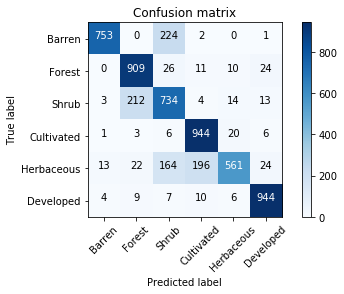

In [14]:
# Confusion matrix
class_probs = np.array(predictions.drop(["label", "image"], axis=1))
y_pred = np.argmax(class_probs, axis=1)
y_true = np.array(predictions["label"])
cm = confusion_matrix(y_true, y_pred)
luc.plot_confusion_matrix(cm, ["Barren", "Forest", "Shrub", "Cultivated", "Herbaceous", "Developed"])

In [15]:
# Accuracy (all classes)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (all classes): ", accuracy)

Accuracy (all classes):  0.823979591837


In [16]:
# Accuracy (Undeveloped, Cultivated, Developed)

# Let 6 be a new label indicating undeveloped land as a whole
y_true[y_true==label_to_number_dict["Barren"]] = 6
y_true[y_true==label_to_number_dict["Forest"]] = 6
y_true[y_true==label_to_number_dict["Shrub"]] = 6
y_true[y_true==label_to_number_dict["Herbaceous"]] = 6
y_pred[y_pred==label_to_number_dict["Barren"]] = 6
y_pred[y_pred==label_to_number_dict["Forest"]] = 6
y_pred[y_pred==label_to_number_dict["Shrub"]] = 6
y_pred[y_pred==label_to_number_dict["Herbaceous"]] = 6

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (Undeveloped, Cultivated, Developed): ", accuracy)

Accuracy (Undeveloped, Cultivated, Developed):  0.940986394558


## Featurize Test Images

In [17]:
model = luc.retrieve_model(cs.TABLE_MODELS, connection_string, "rx_neural_network")

Rows Read: 1, Total Rows Processed: 1, Total Chunk Time: 0.037 seconds 


In [18]:
csv_path = luc.generate_csv(test_image_dir, label_to_number_dict)
test_data = pd.read_csv(csv_path)
print(test_data.head())
print(test_data.shape)

                                               image   label
0  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
1  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
2  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
3  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
4  C:\Users\t-tyrome\Documents\Internship\LandUse...       0
(5880, 2)


In [19]:
refeatureize = True
if refeatureize:
    featurized_test_data = luc.compute_features(test_data, cs.MICROSOFTML_MODEL_NAME, compute_context=None)
    print(featurized_test_data.head())

    test_features_sql = revo.RxSqlServerData(table=cs.TABLE_TEST_FEATURES, connection_string=connection_string)
    revo.rx_data_step(featurized_test_data, test_features_sql, overwrite=True)

Rows Read: 5880, Total Rows Processed: 5880, Total Chunk Time: 0.085 seconds 
Beginning read for block: 1
Rows Read: 5880, Read Time: 0.004, Transform Time: 0
Beginning read for block: 2
No rows remaining. Finished reading data set. 
Elapsed time: 00:21:49.4259931
Finished writing 5880 rows.
Writing completed.
                                               image  label        f0   f1  \
0  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.131557  0.0   
1  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.796923  0.0   
2  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.032556  0.0   
3  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.000000  0.0   
4  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  1.626872  0.0   

         f2        f3        f4        f5        f6        f7  ...   f502  \
0  0.000000  0.000000  0.011541  0.511309  0.000000  0.027638  ...    0.0   
1  0.129240  0.000000  0.028886  0.483552  0.039309  0.055793  ..

## Evaluate Final Model on Test Set
Only run this section once, with the final model based on validation results, in order to prevent overfitting to the test set.

In [20]:
test_features_sql = revo.RxSqlServerData(table=cs.TABLE_TEST_FEATURES, connection_string=connection_string)
predictions = ml.rx_predict(model, data=test_features_sql, extra_vars_to_write=["label", "image"])

number_to_label_dict = {}
for label, number in label_to_number_dict.items():
    number_to_label_dict["Score."+str(number)] = label
print(number_to_label_dict)

predictions=predictions.rename(columns = number_to_label_dict)

predictions_sql = revo.RxSqlServerData(table=cs.TABLE_TEST_PREDICTIONS, connection_string=connection_string)
revo.rx_data_step(predictions, predictions_sql, overwrite=True)
print(predictions.head())

Beginning read starting with row: 1
Rows Read: 5880, Read Time: 0.634, Transform Time: 0
Beginning read starting with row: 5880
No rows remaining. Finished reading data set. 
Elapsed time: 00:00:01.4913837
Finished writing 5880 rows.
Writing completed.
{'Score.5': 'Developed', 'Score.4': 'Herbaceous', 'Score.3': 'Cultivated', 'Score.0': 'Barren', 'Score.2': 'Shrub', 'Score.1': 'Forest'}
Rows Read: 5880, Total Rows Processed: 5880
Total Rows written: 5880, Total time: 0.081
, Total Chunk Time: 0.139 seconds 
                                               image  label    Barren  \
0  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.348495   
1  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.833727   
2  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.308901   
3  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.084916   
4  C:\Users\t-tyrome\Documents\Internship\LandUse...    0.0  0.045815   

     Forest     Shrub  Cultivated  Herbaceous  D

In [21]:
class_probs = np.array(predictions.drop(["label", "image"], axis=1))
y_pred = np.argmax(class_probs, axis=1)
y_true = np.array(predictions["label"])

# Accuracy (all classes)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (all classes): ", accuracy)

Accuracy (all classes):  0.823979591837


In [22]:
# Accuracy (Undeveloped, Cultivated, Developed)

# Let 6 be a new label indicating undeveloped land as a whole
y_true[y_true==label_to_number_dict["Barren"]] = 6
y_true[y_true==label_to_number_dict["Forest"]] = 6
y_true[y_true==label_to_number_dict["Shrub"]] = 6
y_true[y_true==label_to_number_dict["Herbaceous"]] = 6

y_pred[y_pred==label_to_number_dict["Barren"]] = 6
y_pred[y_pred==label_to_number_dict["Forest"]] = 6
y_pred[y_pred==label_to_number_dict["Shrub"]] = 6
y_pred[y_pred==label_to_number_dict["Herbaceous"]] = 6

accuracy = accuracy_score(y_true, y_pred)
print("Accuracy (Undeveloped, Cultivated, Developed): ", accuracy)

Accuracy (Undeveloped, Cultivated, Developed):  0.940986394558
